# Imports

In [1]:
import torch
import gpytorch
from gpytorch.constraints import Interval
import matplotlib.pyplot as plt 
from tqdm import tqdm
import os

from ipywidgets import interact
import glob
import numpy as np
from helper import open_img_as_array
from skimage.measure import label

PATH_TO_DATA = 'C:/Users/waclo/OneDrive/Рабочий стол/CloC dataset/'

IMG_SIZE = (50, 100)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Helper functions

In [2]:
def map_to_cylinder(points):
    return torch.stack((torch.cos(2 * torch.pi * points[:, 1]), torch.sin(2 * torch.pi * points[:, 1]), torch.pi * points[:, 0]), -1)

def clear_small_groups(img, min_size=100):
    img = img.copy()
    cimg = img.copy()
    cimg[img < 255] = 0
    cimg[img == 255] = 1
    limg = label(cimg, background=1)
    unique, counts = np.unique(limg, return_counts=True)
    for i, count in zip(unique, counts):
        if count < min_size:
            img[limg == i] = 255
    return img

# GPModel class

In [3]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, RBF_lengthscale_constraint=None, Periodic_lengthscale_constraint=None):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.likelihood = likelihood
        self.mean_module = gpytorch.means.ZeroMean()
        self.RBF = gpytorch.kernels.RBFKernel(ard_num_dims=3, lengthscale_constraint=RBF_lengthscale_constraint)
        self.Periodic = gpytorch.kernels.PeriodicKernel(ard_num_dims=3, lengthscale_constraint=Periodic_lengthscale_constraint)
        self.covar_module = gpytorch.kernels.ScaleKernel(self.RBF) + gpytorch.kernels.ScaleKernel(self.Periodic)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    def start_training(self, train_x, train_y, num_iter=100, need_plot=True):
        self.train()
        self.likelihood.train()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

        # "Loss" for GPs - the marginal log likelihood
        my_loss = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self)

        history = {"loss": [], 
                "lengthscale": [],
                "noise": []}

        for _ in tqdm(range(num_iter), desc='Training'):
            optimizer.zero_grad()
            output = self(train_x)
            loss = -my_loss(output, train_y)
            loss.backward()
            history["loss"].append(loss.item())
            # lengthscale = self.covar_module.base_kernel.lengthscale.item()
            # history["lengthscale"].append(lengthscale)
            # history["noise"].append(self.likelihood.noise.item())
            optimizer.step()
            
        if need_plot:
            plt.figure(figsize=(10, 5))
            plt.plot(history["loss"])
            plt.title(f'Loss')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
        
    def predict(self, data, num_samples=16, need_plot=True):
        self.eval()
        self.likelihood.eval()

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            sampled_preds = self(data.to(device)).rsample(sample_shape=torch.Size((num_samples,)))

        if need_plot:
            n = int(num_samples ** 0.5)
            _, axs = plt.subplots(n, n, figsize=(20, 10))
            plt.suptitle(f'Samples')
            for i in range(n):
                for j in range(n):
                    axs[i, j].imshow(sampled_preds[i*n+j].cpu().detach().numpy().reshape(IMG_SIZE), cmap='PuOr')
                    axs[i, j].contour(sampled_preds[i*n+j].cpu().detach().numpy().reshape(IMG_SIZE), levels=0, colors='k')
                    axs[i, j].axis('off')
            plt.show()

        return sampled_preds

# Generation of the dataset

### Train set and test set initialization

In [4]:
dx, dy = 1 / IMG_SIZE[0], 1 / IMG_SIZE[1]
xv, yv = torch.meshgrid(torch.linspace(0, 1-dx, IMG_SIZE[0]), torch.linspace(0, 1-dy, IMG_SIZE[1]), indexing="ij")
x_test = torch.cat((
    xv.contiguous().view(xv.numel(), 1),
    yv.contiguous().view(yv.numel(), 1)),
    dim=1)

x_train = torch.cat((x_test[:5*IMG_SIZE[1], :], x_test[-5*IMG_SIZE[1]:, :]), 0)

x_train = map_to_cylinder(x_train)
x_test = map_to_cylinder(x_test)
y_train = torch.cat((torch.ones(5*IMG_SIZE[1]), -torch.ones(5*IMG_SIZE[1])))

### Model initialization and training

Training: 100%|██████████| 100/100 [00:07<00:00, 12.85it/s]


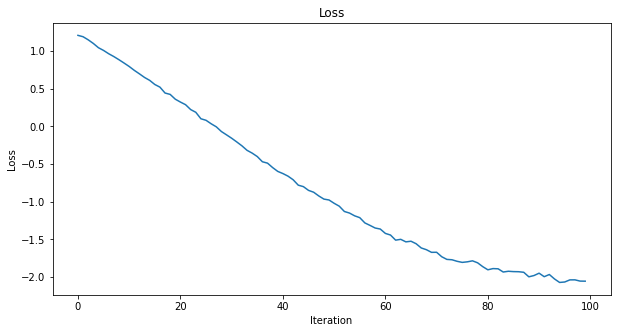

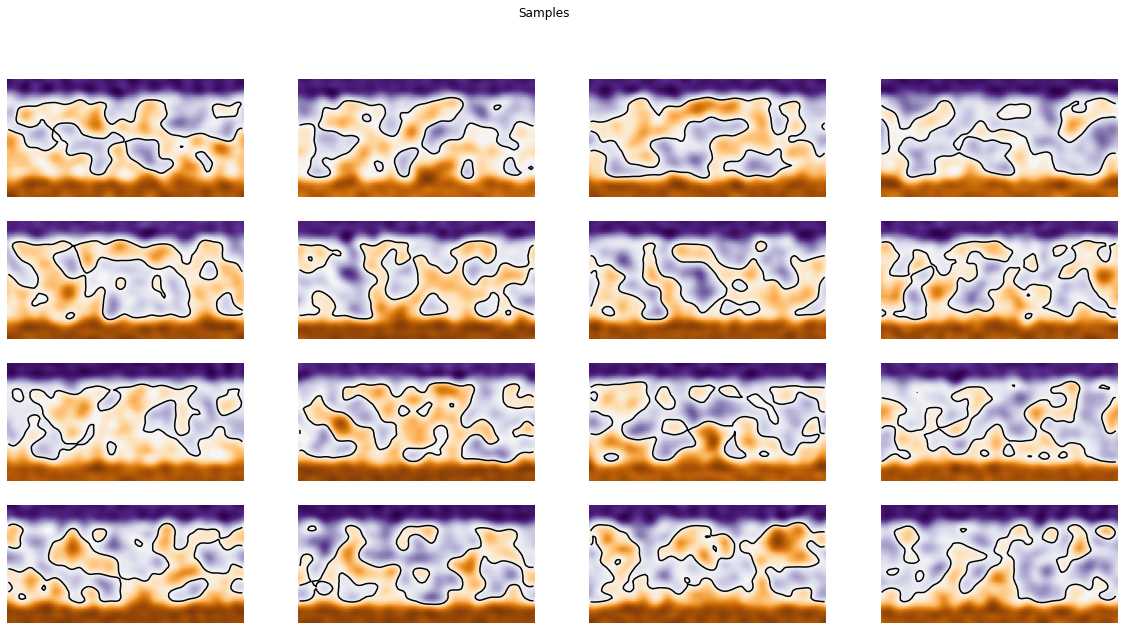

In [5]:
RBF_lengthscale_right = Interval(0.01, 0.17)
Periodic_lengthscale_right = Interval(0.01, 0.15)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x_train, y_train, likelihood, RBF_lengthscale_constraint=RBF_lengthscale_right, Periodic_lengthscale_constraint=Periodic_lengthscale_right)

model = model.to(device)
x_train = x_train.to(device)
y_train = y_train.to(device)

model.start_training(x_train, y_train, num_iter=100, need_plot=True)
samples = model.predict(x_test.to(device))

## Sampling

### Prediction

In [6]:
samples = model.predict(x_test.to(device), num_samples=1000, need_plot=False)
samples = samples.view(-1, *IMG_SIZE).cpu().detach()

### Saving results

In [17]:
os.makedirs(PATH_TO_DATA, exist_ok=True)

for i, sample in enumerate(samples):
    # i want to save images of contour plots in resolution of sample resolution 
    plt.contour(sample, levels=0, colors='k')
    plt.axis('off')
    plt.savefig(PATH_TO_DATA + f'/{i+1:05}.png', bbox_inches='tight', pad_inches=0, facecolor='white')
    # don't display image
    plt.clf()


<Figure size 432x288 with 0 Axes>

# Spliting maps

In [3]:
def split_map(path, x_parts, scale_coef, color, min_size, need_plot=False):
    img = open_img_as_array(path)
    splitted = img.copy()
    if need_plot:
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 3, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Original')
    width, height = img.shape
    ratio = height / width
    y_parts = int(x_parts * ratio)
    dx = width // x_parts
    dy = height // y_parts
    # delta = int(scale_coef * min(dx, dy) // 2)
    delta_x = int(scale_coef * dx / 2)
    delta_y = int(scale_coef * (height / y_parts) / 2)
    # print(f'width={width}\nheight={height}\nratio = {ratio}\nx_parts = {x_parts}\ny_parts = {y_parts}\ndelta_x = {delta_x}\ndelta_y = {delta_y}\ndx={dx}\ndy={dy}')

    for x in range(dx // 2, width, dx):
        # for y in range((1 + (x - dx // 2) // dx % 2) * dy // 2, height, dy):
        for y in range(dy // 2, height, dy):
            # randomize deltas
            # delta_xx = delta_x + np.random.randint(-delta_x // 5, delta_x // 2)
            # delta_yy = delta_y + np.random.randint(-delta_y // 5, delta_y // 2)
            splitted[x-delta_x:x+delta_x, y-delta_y:y+delta_y] = color
    black_pixs = np.sum(splitted < 255)
    if need_plot:
        plt.subplot(1, 3, 2)
        plt.imshow(splitted, cmap='gray')
        plt.title('After splitting')

    cleared = clear_small_groups(splitted, min_size)
    percent_of_cleared = 100 * (1 - np.sum(cleared < 255) / black_pixs)
    if need_plot:
        plt.subplot(1, 3, 3)
        plt.imshow(cleared, cmap='gray')
        plt.title(f'After clearing {percent_of_cleared:.2f}% of black pixels')

@interact(path=glob.glob(PATH_TO_DATA+'*'), x_parts=(2, 10), scale_coef=(0.5, 1, 0.05), min_size=(0, 100), color=(150, 255))
def real_time_split(path=PATH_TO_DATA+'00001.png', x_parts=5, scale_coef=0.85, min_size=10, color=255):
    _ = split_map(path=path, x_parts=x_parts, scale_coef=scale_coef, color=color, min_size=min_size, need_plot=True)


interactive(children=(Dropdown(description='path', options=('C:/Users/waclo/OneDrive/Рабочий стол/CloC dataset…

# Downscaling

In [4]:
def downscale_map(img, sq_size):
    width, height = img.shape
    x_parts = width // sq_size
    y_parts = height // sq_size
    downsampled = np.zeros((x_parts, y_parts))
    for x in range(x_parts):
        for y in range(y_parts):
            downsampled[x, y] = np.sum(img[x*sq_size:(x+1)*sq_size, y*sq_size:(y+1)*sq_size] < 255) == 0
    return downsampled

@interact(path=glob.glob(PATH_TO_DATA+'*'), sq_size=(1, 25))
def _(path=PATH_TO_DATA+'00001.png', sq_size=5):
    img = open_img_as_array(path)
    downsampled = downscale_map(img, sq_size)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Original shape = {img.shape}')
    plt.subplot(1, 2, 2)
    plt.imshow(downsampled, cmap='gray')
    plt.title(f'Downsampled shape = {downsampled.shape}')


interactive(children=(Dropdown(description='path', options=('C:/Users/waclo/OneDrive/Рабочий стол/CloC dataset…

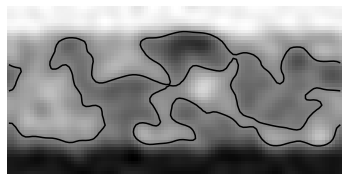

In [29]:
sample = samples[0]
# map values to integers in [0, 255] 
# sample = (sample - sample.min()) / (sample.max() - sample.min()) * 255
# make an array like sampl but with all values = sample.max() using torch
background = -torch.ones_like(sample)

plt.axis('off')
plt.contour(sample, levels=0, colors='k')
plt.imshow(sample*544, cmap='gray')
plt.savefig('test.png', bbox_inches='tight', pad_inches=0, facecolor='white')


In [20]:
sample

tensor([[ 1.0125,  1.0207,  1.0364,  ...,  1.0022,  1.0097,  1.0113],
        [ 0.9761,  0.9902,  1.0124,  ...,  0.9744,  0.9743,  0.9726],
        [ 0.9509,  0.9676,  0.9928,  ...,  0.9639,  0.9549,  0.9482],
        ...,
        [-0.9804, -0.9827, -0.9983,  ..., -1.0323, -1.0188, -0.9959],
        [-0.9743, -0.9754, -0.9876,  ..., -1.0319, -1.0154, -0.9904],
        [-0.9682, -0.9636, -0.9669,  ..., -1.0344, -1.0141, -0.9870]])

In [32]:
def threshold_map(img, threshold):
    return img.abs() < threshold

@interact(threshold=(0, 1.15, 1e-2))
def _(threshold=100):
    img = samples[0]
    print(img.min(), img.max())
    # img = (img - img.min()) / (img.max() - img.min()) * 255
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    # bottom-left corner is (0, 0)

    plt.contour(samples[0], levels=0, colors='k', origin='lower')
    plt.subplot(1, 3, 3)

    plt.imshow(threshold_map(img.abs().max()-img, threshold), cmap='gray')

interactive(children=(FloatSlider(value=1.15, description='threshold', max=1.15, step=0.01), Output()), _dom_c…